# Multi-model Fruit Ripeness Detection System



This notebook contains the model used to classify the ripeness levels of 3 fruits(Papaya,Mango & Banana) into 3 classes(Over Ripe, Ripe & Unripe). Our dataset was made by integrating several datasets from kaggle. A tranfer learning approach, using EfficientNetB7 keras application was used to develop the classification model. The performance of the model was checked using several evaluation metrices, such as F1-score, precision,evaluation matrix and recall. The outputs from the metrices indicated that the model acheived a high level of accuracy in classifying the ripeness levels of fruits. 

## Splitting the dataset 

In [10]:
import splitfolders 


input_folder = '/Users/admin/Downloads/DSGP/Fruit Dataset'


splitfolders.ratio(input_folder, output='/Users/admin/Downloads/DSGP/Fruit Dataset_S', 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None) 

Copying files: 6600 files [00:03, 2174.13 files/s]


## Importing Libraries 

In [11]:
import matplotlib.pyplot as plt 
import numpy as np 
import pathlib
import os
import PIL
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Reshape, Flatten, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

In [12]:
train_p = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/train'
valid_p = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/val'
test_p  = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/test'

## Initialize Image Size

In [13]:
img_size = (224,224)

## Initializing  training, validationg & testing data

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_p,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=img_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_p,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=img_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_p ,
    validation_split=None,
    subset=None,
    shuffle=False,
    batch_size=32,
    image_size=img_size
)

class_names = train_ds.class_names
print(class_names)

Found 4620 files belonging to 3 classes.
Found 1320 files belonging to 3 classes.
Found 660 files belonging to 3 classes.
['Over Ripe', 'Ripe', 'Unripe']


## Plotting Images with Labels

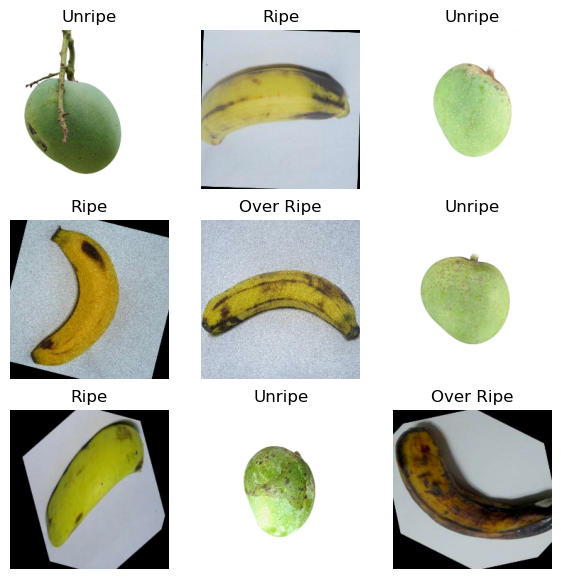

In [15]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

## Data Augmentation , Normalization & shuffling training dataset

In [27]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
# ])

# train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# train_ds = train_ds.shuffle(buffer_size=1000)

In [28]:
no_classes = 3
input_shape = (224,224,3)

## Importing model to implement Tranfer Learning

In [29]:
efficientnet_model = Sequential()

pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling="avg",
    classes=no_classes
)

In [30]:
pretrained_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1

## Freezing layers in the EfficientNetB7

In [31]:
for layer in pretrained_model.layers[:-5]:
    layer.trainable = False

In [32]:
for layer in pretrained_model.layers:
    print(layer.name, layer.trainable)

input_2 False
rescaling_2 False
normalization_1 False
rescaling_3 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block1c_dwconv False
block1c_bn False
block1c_activation False
block1c_se_squeeze False
block1c_se_reshape False
block1c_se_reduce False
block1c_se_expand False
block1c_se_excite False
block1c_project_conv False
block1c_project_bn False
block1c_drop False
block1c_add False
block1d_dwconv False
block1d_bn False
block1d_activation False
block1d_

## Making the classification model

In [33]:
efficientnet_model.add(pretrained_model)
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(256, activation='relu'))
efficientnet_model.add(Dropout(0.3))
efficientnet_model.add(Dense(128, activation='relu'))
efficientnet_model.add(Dropout(0.3))
efficientnet_model.add(Dense(64, activation='relu'))
efficientnet_model.add(Dropout(0.3))
efficientnet_model.add(Dense(32, activation='relu'))
efficientnet_model.add(Dropout(0.3))
# efficientnet_model.add(BatchNormalization())
# efficientnet_model.add(GlobalAveragePooling2D())
# efficientnet_model.add(Flatten())
# efficientnet_model.add(Dense(128, activation='relu'))
# efficientnet_model.add(Dropout(0.3))
# efficientnet_model.add(Dense(3, activation='softmax'))

## Compiling the model

In [34]:
efficientnet_model.compile(
    optimizer= LegacyAdam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

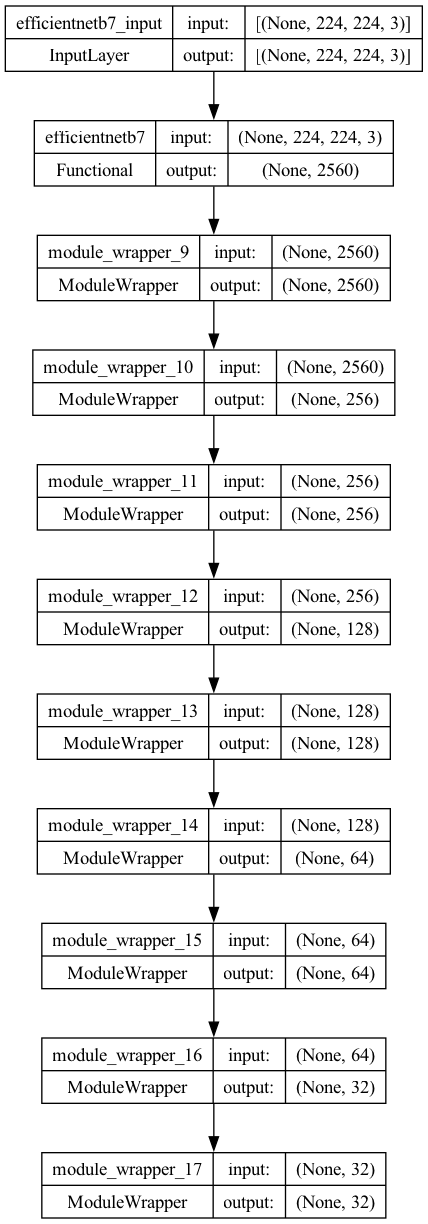

In [35]:
from tensorflow.keras.utils import plot_model

plot_model(efficientnet_model, to_file='model_eff.png',show_shapes=True, show_layer_names=True)

In [37]:
from keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1)
# model_checkp =  ModelCheckpoint('best_model_ripeness_classification.h5', monitor='val_loss', 
#                                 verbose=1, save_best_only=True)

history = efficientnet_model.fit(train_ds, validation_data = val_ds,
          epochs = 30, batch_size = 32, callbacks = [early_stopping])

Epoch 1/30


2024-02-11 10:12:20.644444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:12:25.348700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 108s 641ms/step - loss: 7.9880 - accuracy: 0.3078 - val_loss: 6.1974 - val_accuracy: 0.2773
Epoch 2/30


2024-02-11 10:14:09.151383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:14:13.894558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 108s 635ms/step - loss: 6.9396 - accuracy: 0.2939 - val_loss: 3.4065 - val_accuracy: 0.2242
Epoch 3/30


2024-02-11 10:15:56.856861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 96 of 1000
2024-02-11 10:16:01.709024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 111s 659ms/step - loss: 6.7356 - accuracy: 0.2820 - val_loss: 3.3774 - val_accuracy: 0.3326
Epoch 4/30


2024-02-11 10:17:48.098171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:17:52.857822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 107s 628ms/step - loss: 6.2405 - accuracy: 0.2613 - val_loss: 3.4017 - val_accuracy: 0.3803
Epoch 5/30


2024-02-11 10:19:34.721255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:19:39.448605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 106s 622ms/step - loss: 5.6058 - accuracy: 0.2576 - val_loss: 3.4108 - val_accuracy: 0.1977
Epoch 6/30


2024-02-11 10:21:20.438985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:21:25.163280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 106s 626ms/step - loss: 5.7618 - accuracy: 0.2437 - val_loss: 3.4224 - val_accuracy: 0.0917
Epoch 7/30


2024-02-11 10:23:06.755310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 96 of 1000
2024-02-11 10:23:11.559826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 106s 621ms/step - loss: 5.6081 - accuracy: 0.2517 - val_loss: 3.4378 - val_accuracy: 0.1121
Epoch 8/30


2024-02-11 10:24:52.435150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:24:57.135618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 107s 627ms/step - loss: 5.6022 - accuracy: 0.2422 - val_loss: 3.4417 - val_accuracy: 0.0886
Epoch 9/30


2024-02-11 10:26:38.955891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:26:43.640950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 109s 641ms/step - loss: 5.7990 - accuracy: 0.2182 - val_loss: 3.4529 - val_accuracy: 0.0735
Epoch 10/30


2024-02-11 10:28:27.564951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:28:32.264583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 105s 619ms/step - loss: 5.8768 - accuracy: 0.2208 - val_loss: 3.4495 - val_accuracy: 0.0705
Epoch 11/30


2024-02-11 10:30:12.914098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:30:17.658139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 105s 620ms/step - loss: 5.8236 - accuracy: 0.2167 - val_loss: 3.4638 - val_accuracy: 0.0879
Epoch 12/30


2024-02-11 10:31:58.350833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 98 of 1000
2024-02-11 10:32:03.077969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 105s 620ms/step - loss: 6.4433 - accuracy: 0.2136 - val_loss: 3.4541 - val_accuracy: 0.0636
Epoch 13/30


2024-02-11 10:33:43.736705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 96 of 1000
2024-02-11 10:33:48.548716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 106s 627ms/step - loss: 6.1595 - accuracy: 0.2182 - val_loss: 3.4554 - val_accuracy: 0.0159
Epoch 14/30


2024-02-11 10:35:29.584498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:35:34.320102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 105s 619ms/step - loss: 6.2665 - accuracy: 0.2128 - val_loss: 3.4642 - val_accuracy: 0.0250
Epoch 15/30


2024-02-11 10:37:15.052634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 98 of 1000
2024-02-11 10:37:19.688147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 106s 621ms/step - loss: 7.5967 - accuracy: 0.1907 - val_loss: 3.4237 - val_accuracy: 0.0250
Epoch 16/30


2024-02-11 10:39:00.678107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 95 of 1000
2024-02-11 10:39:05.560227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 106s 621ms/step - loss: 6.6307 - accuracy: 0.2013 - val_loss: 3.4534 - val_accuracy: 0.0098
Epoch 17/30


2024-02-11 10:40:46.360480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:40:51.076821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 106s 620ms/step - loss: 7.3187 - accuracy: 0.1792 - val_loss: 3.4666 - val_accuracy: 0.0114
Epoch 18/30


2024-02-11 10:42:31.988499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 98 of 1000
2024-02-11 10:42:36.603263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 106s 623ms/step - loss: 6.2003 - accuracy: 0.1955 - val_loss: 3.4707 - val_accuracy: 0.0068
Epoch 19/30


2024-02-11 10:44:17.913528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 98 of 1000
2024-02-11 10:44:22.493982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 105s 621ms/step - loss: 5.9215 - accuracy: 0.2006 - val_loss: 3.5323 - val_accuracy: 0.0258
Epoch 20/30


2024-02-11 10:46:03.293080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:46:07.973475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 105s 621ms/step - loss: 6.1092 - accuracy: 0.2039 - val_loss: 3.5349 - val_accuracy: 0.0220
Epoch 21/30


2024-02-11 10:47:48.847064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:47:53.573344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 106s 621ms/step - loss: 6.5088 - accuracy: 0.1968 - val_loss: 3.5198 - val_accuracy: 0.0129
Epoch 22/30


2024-02-11 10:49:34.438399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:49:39.151332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 106s 620ms/step - loss: 8.0671 - accuracy: 0.1697 - val_loss: 12.3754 - val_accuracy: 0.0235
Epoch 23/30


2024-02-11 10:51:19.961975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:51: Filling up shuffle buffer (this may take a while): 97 of 1000
2024-02-11 10:51:24.826930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


145/145 [==============================] - 106s 626ms/step - loss: 9.4701 - accuracy: 0.1361 - val_loss: 3.4888 - val_accuracy: 0.0644
Epoch 23: early stopping
